In [149]:
!pip install Pydub
!pip install PyWavelets
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pywt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
import audioread
from pydub import AudioSegment
import tensorflow as tf
from tensorflow.keras import layers, models
import audioread
import tensorflow_hub as hub
from keras import layers, models, preprocessing
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras import mixed_precision
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
import seaborn as sns

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [84]:
# Load the datasets
file_30_sec = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/features_30_sec.csv'
audio_directory = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original'
#image_directory = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/images_original'

df_30_sec = pd.read_csv(file_30_sec)

# Function to generate summary statistics for audio files
def audio_summary_statistics(audio_directory):
    summary_statistics = []

    for genre_folder in os.listdir(audio_directory):
        genre_path = os.path.join(audio_directory, genre_folder)
        if not os.path.isdir(genre_path):
            continue

        for audio_file in os.listdir(genre_path):
            if audio_file.endswith('.wav'):
                file_path = os.path.join(genre_path, audio_file)

                try:
                    # Load the audio file
                    y, sr = librosa.load(file_path, sr=None)

                    # Calculate summary statistics
                    duration = librosa.get_duration(y=y, sr=sr)
                    mean_amplitude = np.mean(np.abs(y))
                    rms_amplitude = np.sqrt(np.mean(y**2))
                    max_amplitude = np.max(np.abs(y))

                    summary_statistics.append({
                        'Genre': genre_folder,
                        'Filename': audio_file,
                        'Duration (s)': duration,
                        'Sampling Rate': sr,
                        'Mean Amplitude': mean_amplitude,
                        'RMS Amplitude': rms_amplitude,
                        'Max Amplitude': max_amplitude
                    })

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

    # Convert to DataFrame for easier readability
    summary_df = pd.DataFrame(summary_statistics)
    print("\nAudio Summary Statistics Table:")
    print(summary_df)

audio_summary_statistics(audio_directory)

<ipython-input-84-a5d8946a040e>:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original/jazz/jazz.00054.wav: 

Audio Summary Statistics Table:
     Genre         Filename  Duration (s)  Sampling Rate  Mean Amplitude  \
0    blues  blues.00070.wav     30.013333          22050        0.084276   
1    blues  blues.00066.wav     30.013333          22050        0.088565   
2    blues  blues.00029.wav     30.013333          22050        0.100972   
3    blues  blues.00010.wav     30.013333          22050        0.114130   
4    blues  blues.00028.wav     30.013333          22050        0.079170   
..     ...              ...           ...            ...             ...   
994   jazz   jazz.00031.wav     30.013333          22050        0.034432   
995   jazz   jazz.00081.wav     30.013333          22050        0.034261   
996   jazz   jazz.00007.wav     30.013333          22050        0.077327   
997   jazz   jazz.00060.wav     30.013333          22050        0.085595   
998   jazz   jazz.00076.wav

In [172]:
# Load VGGish model from TensorFlow Hub
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# Function to extract VGGish features
def extract_vggish_features(y, sr, file_path):
    try:
        # Resample the audio for VGGish input
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)

        # Ensure input is in float32 format
        y_resampled = np.array(y_resampled, dtype=np.float32)

        # Convert to tensor for the model
        y_tensor = tf.convert_to_tensor(y_resampled, dtype=tf.float32)

        # Extract features using VGGish model
        vggish_features = vggish_model(y_tensor)

        if isinstance(vggish_features, tf.Tensor):
            vggish_features = vggish_features.numpy()

        # Flatten the features to use in ML models
        vggish_features_flattened = vggish_features.flatten()
    except Exception as e:
        print(f"Error extracting VGGish features from {file_path}: {e}")
        vggish_features_flattened = None

    return vggish_features_flattened

# Function to extract features from audio files
def extract_features(file_path, sr=22050, n_mels=128, wavelet='db1', n_mfcc=40, n_chroma=24, hop_length=256):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        y = np.array(y, dtype=np.float32)

        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models

        # Extract wavelet features
        coeffs = pywt.wavedec(y, wavelet, level=5)
        wavelet_features = np.concatenate([np.array(c).flatten() for c in coeffs])

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc_flattened = mfcc.flatten()

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma, hop_length=hop_length)
        chroma_flattened = chroma.flatten()

        # Extract VGGish features
        vggish_features_flattened = extract_vggish_features(y, sr, file_path)

        # Combine all features independently into a dictionary
        features = {
            'mel_spectrogram': mel_spectrogram_flattened,
            'wavelet': wavelet_features,
            'mfcc': mfcc_flattened,
            'chroma': chroma_flattened,
            'vggish': vggish_features_flattened if vggish_features_flattened is not None else np.array([])
        }
    except Exception as e:
        print(f"Error processing audio file {file_path}: {e}")
        features = {
            'mel_spectrogram': np.array([]),
            'wavelet': np.array([]),
            'mfcc': np.array([]),
            'chroma': np.array([]),
            'vggish': np.array([])
        }

    return features

# Function to process the entire dataset and extract features
# and combine them with existing CSV features
def process_dataset(df, audio_directory):
    features = {
        'mel_spectrogram': [],
        'wavelet': [],
        'vggish': [],
        'mfcc': [],
        'chroma': [],
    }
    labels = []

    for idx, row in df.iterrows():
        file_path = os.path.join(audio_directory, row['label'], row['filename'])
        extracted_features = extract_features(file_path)

        # Check if all extracted features are empty
        if all(len(extracted_features[key]) == 0 for key in extracted_features):
            print(f"Skipping row {idx} due to audio extraction issues.")
            continue

        for key in extracted_features:
            features[key].append(extracted_features[key])

        # Add label
        labels.append(row['label'])

    # Convert features lists to NumPy arrays
    for key in features:
        features[key] = np.array(features[key], dtype=object)

    labels = np.array(labels)

    return features, labels

# Function to unify feature lengths based on the maximum length of each feature type
def unify_feature_lengths(features):
    unified_features = {}
    for key in features:
        # Find the maximum length among all samples for each feature type
        max_len = max(len(feature) for feature in features[key])

        # Pad each feature to the maximum length
        padded_features = [np.pad(feature, (0, max_len - len(feature)), 'constant') for feature in features[key]]
        unified_features[key] = np.array(padded_features, dtype=np.float32)

    return unified_features

# Function to standardize features
def standardize_features(features):
    standardized_features = {}
    scalers = {}

    for key in features:
        standardized_features[key] = []
        scalers[key] = []
        for feature in features[key]:
            feature = feature.reshape(-1, 1)
            scaler = StandardScaler()
            standardized_feature = scaler.fit_transform(feature).flatten()
            standardized_features[key].append(standardized_feature)
            scalers[key].append(scaler)
        standardized_features[key] = np.array(standardized_features[key], dtype=np.float32)

    return standardized_features

# Function to print summary statistics of standardized features
def print_standardized_summary_statistics(features):
    summary_statistics = []

    for feature_name, feature_data in features.items():
        feature_shape = np.array(feature_data).shape

        # Flatten all samples to calculate unified statistics
        flattened_data = np.concatenate([seq.flatten() for seq in feature_data])

        # Calculate statistical metrics
        mean = np.mean(flattened_data)
        std = np.std(flattened_data)
        min_val = np.min(flattened_data)
        max_val = np.max(flattened_data)

        summary_statistics.append({
            'Feature': feature_name,
            'Shape': feature_shape,
            'Mean': mean,
            'Std': std,
            'Min': min_val,
            'Max': max_val
        })

    summary_df = pd.DataFrame(summary_statistics)
    print("\nSummary Statistics Table:")
    print(summary_df)

# Function to plot deep-learning models performance
def plot_model_training(history):
    # Retrieve data from the history object for accuracy and loss
    val_accuracy = history.history.get('val_accuracy')
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy')
    loss = history.history.get('loss')

    # Set x-axis as the number of epochs
    epochs = range(1, len(accuracy) + 1)

    # Create a figure with two subplots for accuracy and loss
    plt.figure(figsize=(14, 6))

    # Subplot 1: Validation and Training Accuracy
    plt.subplot(1, 2, 1)
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='b')
    if accuracy:
        plt.plot(epochs, accuracy, label='Training Accuracy', color='g', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation and Training Accuracy Over Epochs')
    plt.legend()

    # Subplot 2: Validation and Training Loss
    plt.subplot(1, 2, 2)
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss', color='r')
    if loss:
        plt.plot(epochs, loss, label='Training Loss', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation and Training Loss Over Epochs')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

def plot_prediction_heatmap(model, test_features, test_labels, label_encoder, title="Prediction Heatmap"):
    predictions = model.model.predict(test_features)
    # If the output is probability distributions (softmax), use np.argmax to get predicted labels
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        predicted_labels = np.argmax(predictions, axis=1)
    else:
        predicted_labels = (predictions > 0.5).astype(int).flatten()  # For binary classification

    # Inverse transform the numerical labels to get original class labels
    true_labels_decoded = label_encoder.inverse_transform(test_labels)
    predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels_decoded, predicted_labels_decoded, labels=label_encoder.classes_)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [153]:
# Extract features from audio directory
features, labels = process_dataset(df_30_sec, audio_directory)

# Unify and standardize features
features = unify_feature_lengths(features)
features = standardize_features(features)

# Generate the summary statistics report for standardized features
print_standardized_summary_statistics(features)

# Split dataset into training, validation, and test sets
train_features = {}
val_features = {}
test_features = {}
# Create a combined list of feature dictionaries and labels for consistent splitting
combined_data = list(zip([{key: features[key][i] for key in features} for i in range(len(labels))], labels))

# Split combined data
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42, stratify=labels)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=[label for _, label in train_data])

# Separate features and labels after splitting
for key in features:
    train_features[key] = [data[0][key] for data in train_data]
    val_features[key] = [data[0][key] for data in val_data]
    test_features[key] = [data[0][key] for data in test_data]

train_labels = np.array([data[1] for data in train_data])
val_labels = np.array([data[1] for data in val_data])
test_labels = np.array([data[1] for data in test_data])

# Encode labels as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Save the original category labels
class_names = label_encoder.classes_

train_labels = label_encoder.transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)
num_classes = len(set(labels))

# Pad features again to decrease the length for CUDNN
lengths = [len(seq) for feature in train_features.values() for seq in feature]
max_len = min(15000, int(np.percentile(lengths, 70)))
padded_train_features = {key+'_input': pad_sequences(train_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in train_features}
padded_val_features = {key+'_input': pad_sequences(val_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in val_features}
padded_test_features = {key+'_input': pad_sequences(test_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in test_features}

for key in padded_train_features:
    padded_train_features[key] = np.expand_dims(padded_train_features[key], axis=-1)
    padded_val_features[key] = np.expand_dims(padded_val_features[key], axis=-1)
    padded_test_features[key] = np.expand_dims(padded_test_features[key], axis=-1)

<ipython-input-151-eeb2b31de238>:34: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing audio file /content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original/jazz/jazz.00054.wav: 
Skipping row 554 due to audio extraction issues.

Summary Statistics Table:
           Feature          Shape          Mean       Std        Min  \
0  mel_spectrogram  (999, 168960) -1.495585e-09  1.000001  -5.203684   
1          wavelet  (999, 675808)  2.918025e-12  0.999994 -57.596069   
2           vggish    (999, 3968) -2.781127e-10  1.000000  -6.203063   
3             mfcc  (999, 105600)  8.562732e-11  0.999999 -22.557358   
4           chroma   (999, 63360) -3.741374e-10  1.000000  -2.410709   

         Max  
0   4.076281  
1  56.825695  
2   9.268440  
3  10.307214  
4   3.719159  


# Set up for Deep-Learning Models

In [86]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Deep-Learning: CNNs

In [177]:
class MusicGenreCNNModel:
    def __init__(self, input_shapes, num_classes, lr_max=1e-2, lr_min=1e-6, warmup_epochs=10, epochs=250, batch_size=64):
        self.input_shapes = input_shapes
        self.num_classes = num_classes
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.optimizer = None
        self.lr_callback = None
        self.history = None

        # Set mixed precision policy
        self.policy = tf.keras.mixed_precision.set_global_policy('float32')

        # Create and compile the model
        self._initialize_model()

    def _initialize_model(self):
        """Initialize and compile the CNN model."""
        # Define the optimizer
        self.optimizer = Adam(learning_rate=self.lr_max)

        # Set the learning rate scheduler callback with cosine annealing and warm-up
        T_max = self.epochs - self.warmup_epochs
        self.lr_callback = LearningRateScheduler(lambda epoch: self.combined_lr_schedule(epoch, self.lr_max, self.lr_min, self.warmup_epochs, T_max))

        # Create the CNN model
        self.model = self._create_cnn_model(self.input_shapes, self.num_classes)

        # Compile the model
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def _create_cnn_model(self, input_shapes, num_classes):
        """Create the CNN model for music genre classification."""
        inputs = []
        processed_features = []

        for key, shape in input_shapes.items():
            input_layer = layers.Input(shape=(None, 1), name=f"{key}_input")
            inputs.append(input_layer)

            if key == 'mel_spectrogram' or key == 'chroma':
                # Use Conv2D for Mel spectrogram and Chroma with Global Average Pooling
                time_dimension = layers.Lambda(lambda x: tf.shape(x)[1] // 128)(input_layer)
                padded_input = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, 128 - tf.shape(x)[1] % 128], [0, 0]]))(input_layer)
                reshaped_input = layers.Reshape((-1, 128, 1))(padded_input)
                x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(reshaped_input)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout2D(0.2)(x)
                residual = x
                residual = layers.Conv2D(32, (1, 1), padding='same')(residual)
                x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout2D(0.2)(x)
                x = layers.Add()([x, residual])
                x = layers.MaxPooling2D((2, 2))(x)
                x = layers.GlobalAveragePooling2D()(x)
            processed_features.append(x)

        combined = layers.concatenate(processed_features)
        x = layers.Dense(64, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        output_layer = layers.Dense(num_classes, activation='softmax')(x)

        return models.Model(inputs=inputs, outputs=output_layer)

    def combined_lr_schedule(self, epoch, lr_max, lr_min, warmup_epochs, T_max):
        """Combined warm-up and cosine annealing learning rate schedule."""
        if epoch < warmup_epochs:
            # Warm-up phase: gradually increase learning rate
            return lr_min + (lr_max - lr_min) * (epoch / warmup_epochs)
        else:
            # Cosine annealing phase after warm-up
            return lr_min + (lr_max - lr_min) * (1 + math.cos((epoch - warmup_epochs) * math.pi / T_max)) / 2

    def train(self, train_features, train_labels, val_features, val_labels):
        """Train the model."""
        self.history = self.model.fit(
            train_features,
            train_labels.astype('int32'),
            validation_data=(val_features, val_labels.astype('int32')),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[self.lr_callback]
        )

    def evaluate(self, test_features, test_labels):
        """Evaluate the model on the test set."""
        test_loss, test_accuracy = self.model.evaluate(
            test_features,
            test_labels.astype('int32')
        )
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

    def predict(self, test_features, test_labels):
        """Make predictions on the test set."""
        predictions = self.model.predict(test_features)
        predicted_labels = np.argmax(predictions, axis=1)
        print(f"Predicted Labels: {predicted_labels}")
        print(f"True Labels: {test_labels.astype('int32')}")

# Define input shapes for CNNs
input_shapes_cnn = {
    'mel_spectrogram': (None, 1),
    'chroma': (None, 1),
}


# Create and train the CNN model
music_genre_cnn_model = MusicGenreCNNModel(input_shapes_cnn, num_classes)
music_genre_cnn_model.train(padded_train_features, train_labels, padded_val_features, val_labels)
music_genre_cnn_model.evaluate(padded_test_features, test_labels)
music_genre_cnn_model.predict(padded_test_features, test_labels)

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_input     │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chroma_input (InputLayer) │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_73 (Lambda)        │ (None, None, 1)        │              0 │ mel_spectrogram_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_75 (Lambda)        │ (None, None, 1)        │              0 │ chroma_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_36 (Reshape)      │ (None, None, 128, 1)   │              0 │ lambda_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_37 (Reshape)      │ (None, None, 128, 1)   │              0 │ lambda_75[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, None, 128, 16)  │            160 │ reshape_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_111 (Conv2D)       │ (None, None, 128, 16)  │            160 │ reshape_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_122   │ (None, None, 128, 16)  │             64 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_124   │ (None, None, 128, 16)  │             64 │ conv2d_111[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_72      │ (None, None, 128, 16)  │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_74      │ (None, None, 128, 16)  │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_110 (Conv2D)       │ (None, None, 128, 32)  │          4,640 │ spatial_dropout2d_72[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, None, 128, 32)  │          4,640 │ spatial_dropout2d_74[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_123   │ (None, None, 128, 32)  │            128 │ conv2d_110[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_125   │ (None, None, 128, 32)  │            128 │ conv2d_113[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 16,138 (63.04 KB)

 Trainable params: 15,818 (61.79 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 838ms/step - accuracy: 0.0987 - loss: 2.9754 - val_accuracy: 0.0850 - val_loss: 2.3163 - learning_rate: 1.0000e-06
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1272 - loss: 2.7787 - val_accuracy: 0.1100 - val_loss: 2.3019 - learning_rate: 0.0010
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2117 - loss: 2.4398 - val_accuracy: 0.1050 - val_loss: 2.2776 - learning_rate: 0.0020
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2344 - loss: 2.1605 - val_accuracy: 0.1200 - val_loss: 2.2492 - learning_rate: 0.0030
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2723 - loss: 2.0533 - val_accuracy: 0.1050 - val_loss: 2.2430 - learning_rate: 0.0040
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3117 - loss: 1.8789 - val_accuracy: 0.1000 - val_loss: 2.2790 - learning_rate: 0.0050
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3268 - loss: 1.7

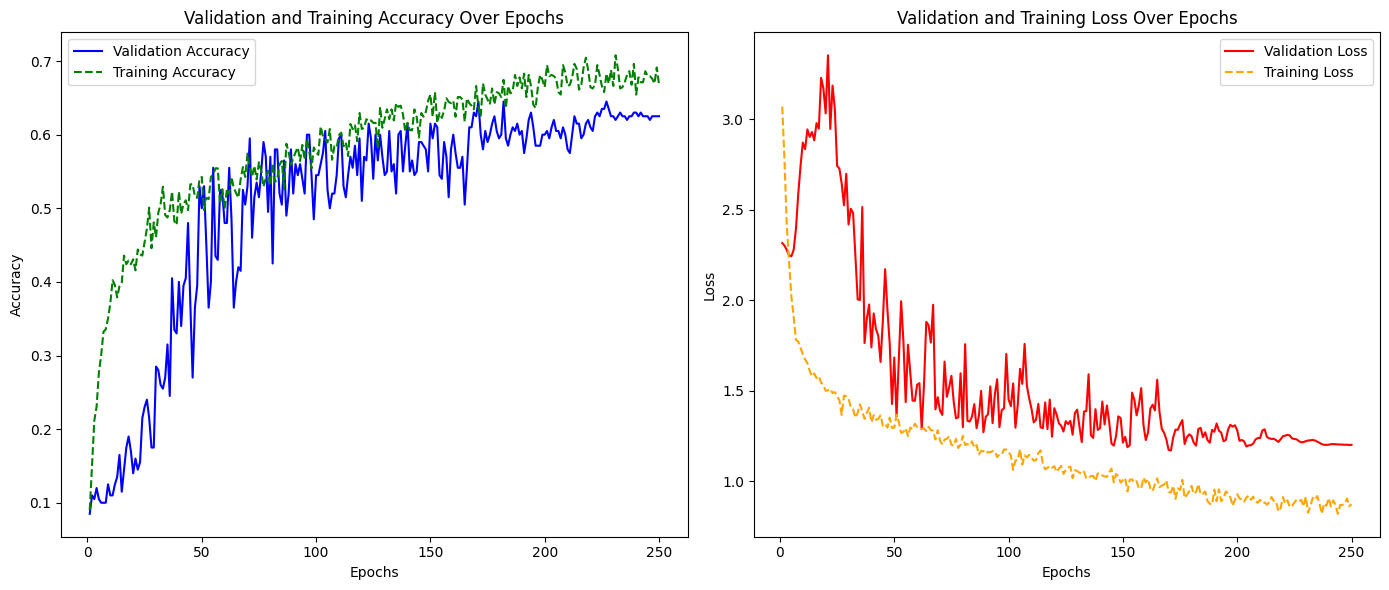

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


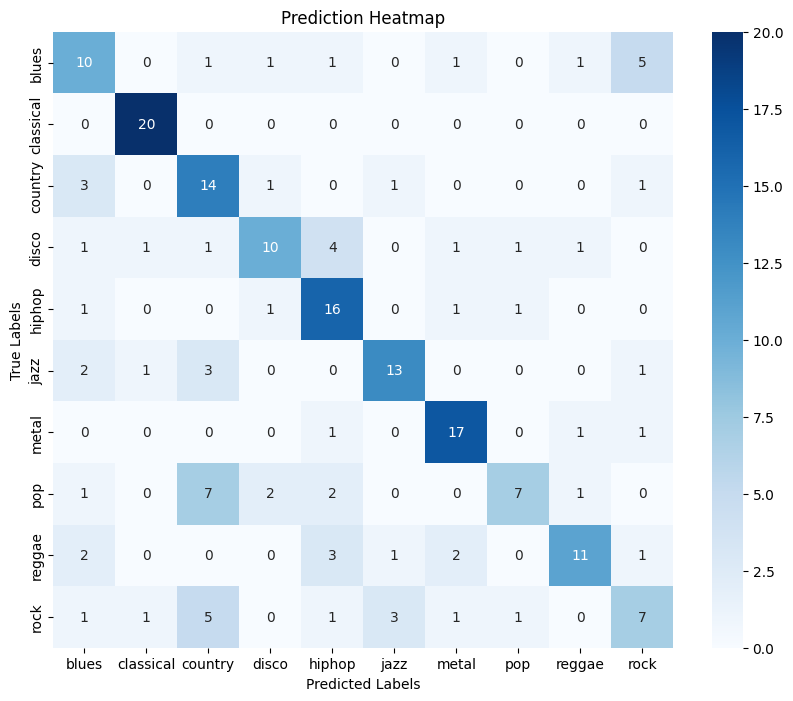

In [178]:
plot_model_training(music_genre_cnn_model.history)
plot_prediction_heatmap(music_genre_cnn_model, padded_test_features, test_labels, label_encoder)

# Deep-Learning: RNNs

In [179]:
class MusicGenreRNNModel:
    def __init__(self, input_shapes, num_classes, lr_max=1e-3, lr_min=1e-6, warmup_epochs=10, epochs=200, batch_size=64):
        self.input_shapes = input_shapes
        self.num_classes = num_classes
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.optimizer = None
        self.lr_callback = None
        self.history = None
        self.policy = tf.keras.mixed_precision.set_global_policy('float32')
        self._initialize_model()

    def _initialize_model(self):
        """Initialize and compile the RNN model."""
        self.optimizer = Adam(learning_rate=self.lr_max)

        T_max = self.epochs - self.warmup_epochs
        self.lr_callback = LearningRateScheduler(lambda epoch: self.combined_lr_schedule(epoch, self.lr_max, self.lr_min, self.warmup_epochs, T_max))

        # Create the RNN model
        self.model = self._create_rnn_model(self.input_shapes, self.num_classes)

        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def _create_rnn_model(self, input_shapes, num_classes):
        """Create the RNN model for music genre classification."""
        inputs = []
        processed_features = []

        for key, shape in input_shapes.items():
            input_layer = layers.Input(shape=(None, 1), name=f"{key}_input")
            inputs.append(input_layer)

            if key == 'wavelet' or key == 'mfcc':
                # Use Bidirectional LSTM for wavelet and mfcc features
                x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_layer)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout1D(0.3)(x)
                x = layers.GlobalAveragePooling1D()(x)
            processed_features.append(x)

        combined = layers.concatenate(processed_features)
        x = layers.Dense(128, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        output_layer = layers.Dense(num_classes, activation='softmax')(x)

        return models.Model(inputs=inputs, outputs=output_layer)

    def combined_lr_schedule(self, epoch, lr_max, lr_min, warmup_epochs, T_max):
        """Combined warm-up and cosine annealing learning rate schedule."""
        if epoch < warmup_epochs:
            return lr_min + (lr_max - lr_min) * (epoch / warmup_epochs)
        else:
            return lr_min + (lr_max - lr_min) * (1 + math.cos((epoch - warmup_epochs) * math.pi / T_max)) / 2

    def train(self, train_features, train_labels, val_features, val_labels):
        """Train the model."""
        self.history = self.model.fit(
            train_features,
            train_labels.astype('int32'),
            validation_data=(val_features, val_labels.astype('int32')),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[self.lr_callback]
        )

    def evaluate(self, test_features, test_labels):
        """Evaluate the model on the test set."""
        test_loss, test_accuracy = self.model.evaluate(
            test_features,
            test_labels.astype('int32')
        )
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

    def predict(self, test_features, test_labels):
        """Make predictions on the test set."""
        predictions = self.model.predict(test_features)
        predicted_labels = np.argmax(predictions, axis=1)
        print(f"Predicted Labels: {predicted_labels}")
        print(f"True Labels: {test_labels.astype('int32')}")

# Define input shapes for RNNs
input_shapes_rnn = {
    'wavelet': (None, 1),
    'mfcc': (None, 1),
}

# Create and train the RNN model
music_genre_rnn_model = MusicGenreRNNModel(input_shapes_rnn, num_classes)
music_genre_rnn_model.train(padded_train_features, train_labels, padded_val_features, val_labels)
music_genre_rnn_model.evaluate(padded_test_features, test_labels)
music_genre_rnn_model.predict(padded_test_features, test_labels)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ wavelet_input             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_22          │ (None, None, 64)       │          8,704 │ wavelet_input[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_23          │ (None, None, 64)       │          8,704 │ mfcc_input[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_127   │ (None, None, 64)       │            256 │ bidirectional_22[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, None, 64)       │            256 │ bidirectional_23[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_22      │ (None, None, 64)       │              0 │ batch_normalization_1… │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_23      │ (None, None, 64)       │              0 │ batch_normalization_1… │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ spatial_dropout1d_22[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ spatial_dropout1d_23[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_29            │ (None, 128)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 128)            │         16,512 │ concatenate_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, 128)            │            512 │ dense_58[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 36,234 (141.54 KB)

 Trainable params: 35,722 (139.54 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.1266 - loss: 3.0804 - val_accuracy: 0.0850 - val_loss: 2.2975 - learning_rate: 1.0000e-06
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1000 - loss: 3.2209 - val_accuracy: 0.0850 - val_loss: 2.2958 - learning_rate: 1.0090e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1398 - loss: 3.1093 - val_accuracy: 0.0900 - val_loss: 2.2937 - learning_rate: 2.0080e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1273 - loss: 2.9146 - val_accuracy: 0.1250 - val_loss: 2.2917 - learning_rate: 3.0070e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1646 - loss: 2.8000 - val_accuracy: 0.1000 - val_loss: 2.2900 - learning_rate: 4.0060e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1559 - loss: 2.7430 - val_accuracy: 0.1100 - val_loss: 2.2884 - learning_rate: 5.0050e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1987 

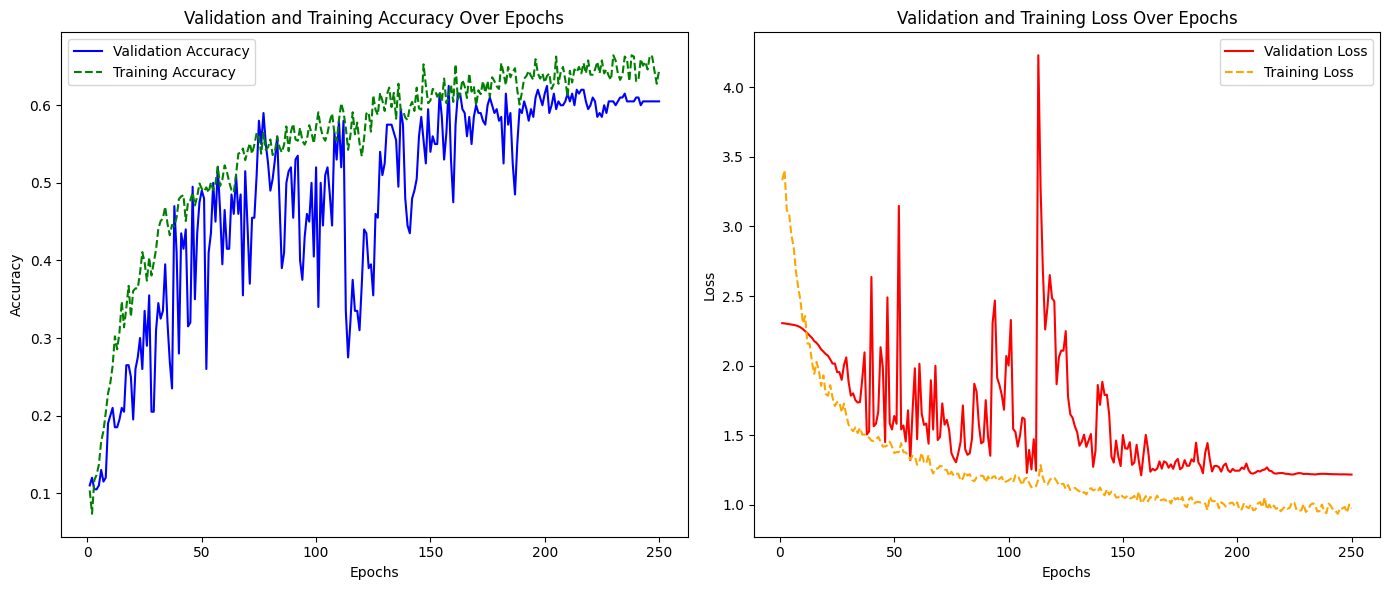

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step


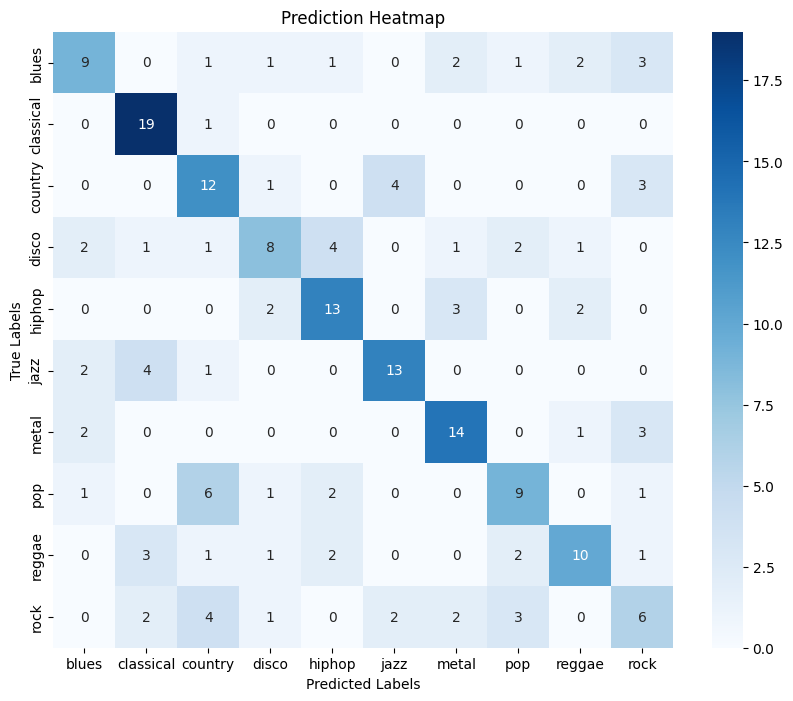

In [175]:
plot_model_training(music_genre_rnn_model.history)
plot_prediction_heatmap(music_genre_rnn_model, padded_test_features, test_labels, label_encoder)

# Deep-Learning: Hybrid CNNs & RNNs with Transfer Learning

In [78]:
class MusicGenreHybridModel:
    def __init__(self, input_shapes, num_classes, lr_max=1e-3, lr_min=1e-6, warmup_epochs=10, epochs=250, batch_size=64):
        self.input_shapes = input_shapes
        self.num_classes = num_classes
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.optimizer = None
        self.lr_callback = None
        self.history = None
        self.policy = tf.keras.mixed_precision.set_global_policy('float32')
        self._initialize_model()

    def _initialize_model(self):
        """Initialize and compile the hybrid model."""
        self.optimizer = Adam(learning_rate=self.lr_max)

        T_max = self.epochs - self.warmup_epochs
        self.lr_callback = LearningRateScheduler(lambda epoch: self.combined_lr_schedule(epoch, self.lr_max, self.lr_min, self.warmup_epochs, T_max))

        # Create the hybrid model
        self.model = self._create_hybrid_model(self.input_shapes, self.num_classes)

        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def _create_hybrid_model(self, input_shapes, num_classes):
        """Create the hybrid model for music genre classification."""
        inputs = []
        processed_features = []

        for key, shape in input_shapes.items():
            input_layer = layers.Input(shape=(None, 1), name=f"{key}_input")
            inputs.append(input_layer)

            if key == 'mel_spectrogram' or key == 'chroma':
                time_dimension = layers.Lambda(lambda x: tf.shape(x)[1] // 128)(input_layer)
                padded_input = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, 128 - tf.shape(x)[1] % 128], [0, 0]]))(input_layer)
                reshaped_input = layers.Reshape((-1, 128, 1))(padded_input)
                x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(reshaped_input)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout2D(0.2)(x)
                residual = x
                residual = layers.Conv2D(32, (1, 1), padding='same')(residual)
                x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout2D(0.2)(x)
                x = layers.Add()([x, residual])
                x = layers.MaxPooling2D((2, 2))(x)
                x = layers.GlobalAveragePooling2D()(x)
            elif key == 'wavelet' or key == 'mfcc':
                x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_layer)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout1D(0.3)(x)
                x = layers.GlobalAveragePooling1D()(x)
            elif key == 'vggish':
                x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_layer)
                x = layers.BatchNormalization()(x)
                x = layers.SpatialDropout1D(0.3)(x)
                x = layers.Bidirectional(layers.LSTM(16))(x)
                x = layers.BatchNormalization()(x)
                x = layers.GlobalAveragePooling1D()(x)
            processed_features.append(x)

        combined = layers.concatenate(processed_features)
        x = layers.Dense(128, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        output_layer = layers.Dense(num_classes, activation='softmax')(x)

        return models.Model(inputs=inputs, outputs=output_layer)

    def combined_lr_schedule(self, epoch, lr_max, lr_min, warmup_epochs, T_max):
        """Combined warm-up and cosine annealing learning rate schedule."""
        if epoch < warmup_epochs:
            return lr_min + (lr_max - lr_min) * (epoch / warmup_epochs)
        else:
            return lr_min + (lr_max - lr_min) * (1 + math.cos((epoch - warmup_epochs) * math.pi / T_max)) / 2

    def train(self, train_features, train_labels, val_features, val_labels):
        """Train the model."""
        self.history = self.model.fit(
            train_features,
            train_labels.astype('int32'),
            validation_data=(val_features, val_labels.astype('int32')),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[self.lr_callback]
        )

    def evaluate(self, test_features, test_labels):
        """Evaluate the model on the test set."""
        test_loss, test_accuracy = self.model.evaluate(
            test_features,
            test_labels.astype('int32')
        )
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

    def predict(self, test_features, test_labels):
        """Make predictions on the test set."""
        predictions = self.model.predict(test_features)
        predicted_labels = np.argmax(predictions, axis=1)
        print(f"Predicted Labels: {predicted_labels}")
        print(f"True Labels: {test_labels.astype('int32')}")

input_shapes_hybrid = {
    'mel_spectrogram': (None, 1),
    'wavelet': (None, 1),
    'mfcc': (None, 1),
    'chroma': (None, 1),
}

music_genre_hybrid_model = MusicGenreHybridModel(input_shapes_hybrid, num_classes)
music_genre_hybrid_model.train(padded_train_features, train_labels, padded_val_features, val_labels)
music_genre_hybrid_model.evaluate(padded_test_features, test_labels)
music_genre_hybrid_model.predict(padded_test_features, test_labels)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_input     │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chroma_input (InputLayer) │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_61 (Lambda)        │ (None, None, 1)        │              0 │ mel_spectrogram_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_63 (Lambda)        │ (None, None, 1)        │              0 │ chroma_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_30 (Reshape)      │ (None, None, 128, 1)   │              0 │ lambda_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_31 (Reshape)      │ (None, None, 128, 1)   │              0 │ lambda_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, None, 128, 16)  │            160 │ reshape_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, None, 128, 16)  │            160 │ reshape_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, None, 128, 16)  │             64 │ conv2d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_106   │ (None, None, 128, 16)  │             64 │ conv2d_93[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_60      │ (None, None, 128, 16)  │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_62      │ (None, None, 128, 16)  │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, None, 128, 32)  │          4,640 │ spatial_dropout2d_60[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, None, 128, 32)  │          4,640 │ spatial_dropout2d_62[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_103   │ (None, None, 128, 32)  │            128 │ conv2d_92[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wavelet_input             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 55,498 (216.79 KB)

 Trainable params: 54,794 (214.04 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1121 - loss: 3.0990 - val_accuracy: 0.1000 - val_loss: 2.3053 - learning_rate: 1.0000e-06
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1034 - loss: 3.1269 - val_accuracy: 0.1100 - val_loss: 2.3011 - learning_rate: 1.0090e-04
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1215 - loss: 2.9309 - val_accuracy: 0.2150 - val_loss: 2.2962 - learning_rate: 2.0080e-04
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1786 - loss: 2.6103 - val_accuracy: 0.2050 - val_loss: 2.2902 - learning_rate: 3.0070e-04
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1822 - loss: 2.5454 - val_accuracy: 0.1700 - val_loss: 2.2824 - learning_rate: 4.0060e-04
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2539 - loss: 2.2942 - val_accuracy: 0.1250 - val_loss: 2.2756 - learning_rate: 5.0050e-04
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2314 

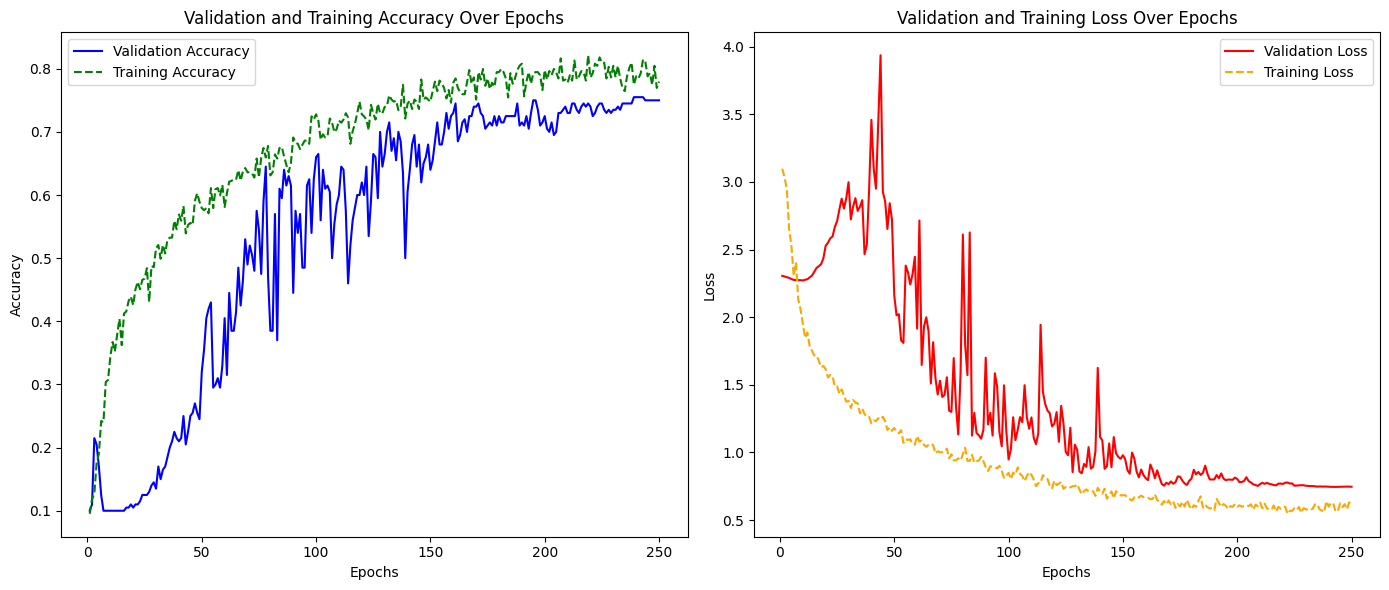

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step


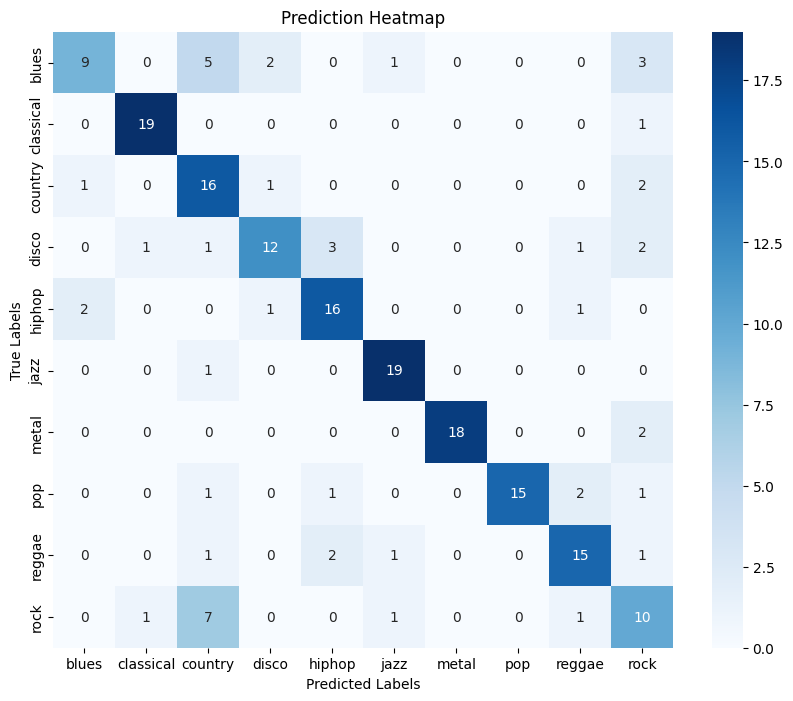

In [176]:
plot_model_training(music_genre_hybrid_model.history)
plot_prediction_heatmap(music_genre_hybrid_model, padded_test_features, test_labels, label_encoder)

# Set up for Baseline Models

In [185]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

# Function to extract and flatten padded features for Logistic Regression model
def extract_baseline_features(features_dict):
    combined_features = []

    for feature in features_dict:
        if 'vggish_input' in feature:
            # Skip vggish features
            continue
        feature_data = features_dict[feature]
        # Flatten 3D shape (num_samples, sequence_length, 1) to 2D shape (num_samples, sequence_length)
        feature_data_flattened = feature_data.reshape(feature_data.shape[0], -1)
        combined_features.append(feature_data_flattened)

    # Check if there are any features to concatenate
    if len(combined_features) == 0:
        return np.array([])

    # Horizontally stack the selected features
    combined_features = np.hstack(combined_features)

    return combined_features

# Extract and pad features for training, validation, and testing
train_baseline = extract_baseline_features(padded_train_features)
val_baseline= extract_baseline_features(padded_val_features)
test_baseline = extract_baseline_features(padded_test_features)

# Convert labels back to original names
target_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Baseline for CNNs: Logistic

In [182]:
# Create Logistic regression model
logistic = LogisticRegression(
    C=5,
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1,
    random_state=SEED)

logistic.fit(train_baseline, train_labels)

# Predict on validation and test sets
val_predictions_logistic = logistic.predict(val_baseline)
val_accuracy_logistic = accuracy_score(val_labels, val_predictions_logistic)

test_predictions_logistic = logistic.predict(test_baseline)
test_accuracy_logistic = accuracy_score(test_labels, test_predictions_logistic)

print(f"Validation Accuracy for Logistic: {val_accuracy_logistic :.4f}")
print(f"Test Accuracy for Logistic: {test_accuracy_logistic:.4f}")
print("Classification Report for Logistic:\n", classification_report(test_labels, test_predictions_logistic, target_names=target_names))

Validation Accuracy for Logistic: 0.4300
Test Accuracy for Logistic: 0.4500
Classification Report for Logistic:
               precision    recall  f1-score   support

       blues       0.17      0.30      0.21        20
   classical       0.68      0.85      0.76        20
     country       0.38      0.45      0.41        20
       disco       0.43      0.15      0.22        20
      hiphop       0.50      0.25      0.33        20
        jazz       0.36      0.70      0.47        20
       metal       0.75      0.60      0.67        20
         pop       0.60      0.75      0.67        20
      reggae       0.75      0.30      0.43        20
        rock       0.30      0.15      0.20        20

    accuracy                           0.45       200
   macro avg       0.49      0.45      0.44       200
weighted avg       0.49      0.45      0.44       200



# Baseline for RNNs: SGD

In [183]:
# Create SGD Classifier model
sgd = SGDClassifier(loss='hinge',
                          alpha=1e-4,
                          max_iter=1000,
                          class_weight='balanced',
                          random_state=SEED)

# Train SGD Classifier
sgd.fit(train_baseline, train_labels)

# Predict on validation and test sets
val_predictions_sgd = sgd.predict(val_baseline)
val_accuracy_sgd = accuracy_score(val_labels, val_predictions_sgd)

test_predictions_sgd = sgd.predict(test_baseline)
test_accuracy_sgd = accuracy_score(test_labels, test_predictions_sgd)

print(f"Validation Accuracy for SGD Classifier: {val_accuracy_sgd:.4f}")
print(f"Test Accuracy for SGD Classifier: {test_accuracy_sgd:.4f}")
print("Test Classification Report for SGD Classifier:\n", classification_report(test_labels, test_predictions_sgd, target_names=target_names))

Validation Accuracy for SGD Classifier: 0.3800
Test Accuracy for SGD Classifier: 0.3800
Test Classification Report for SGD Classifier:
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.54      0.75      0.62        20
     country       0.25      0.70      0.37        20
       disco       0.33      0.10      0.15        20
      hiphop       0.19      0.25      0.21        20
        jazz       0.36      0.20      0.26        20
       metal       0.53      0.95      0.68        20
         pop       0.61      0.55      0.58        20
      reggae       0.31      0.20      0.24        20
        rock       0.40      0.10      0.16        20

    accuracy                           0.38       200
   macro avg       0.35      0.38      0.33       200
weighted avg       0.35      0.38      0.33       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Baseline for Hybrid: Random Forest

In [184]:
# Create Random Forest model
rf = RandomForestClassifier(n_estimators=300,
                            class_weight='balanced',
                            min_samples_leaf=3,
                            max_depth=10,
                            n_jobs=-1,
                            random_state=SEED)

rf.fit(train_baseline, train_labels)

val_predictions_rf = rf.predict(val_baseline)
val_accuracy_rf = accuracy_score(val_labels, val_predictions_rf)

test_predictions_rf = rf.predict(test_baseline)
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)

print(f"Validation Accuracy for Random Forest: {val_accuracy_rf:.4f}")
print(f"Test Accuracy for Random Forest: {test_accuracy_rf:.4f}")
print("Test Classification Report for Random Forest:\n", classification_report(test_labels, test_predictions_rf, target_names=target_names))

Validation Accuracy for Random Forest: 0.5450
Test Accuracy for Random Forest: 0.5500
Test Classification Report for Random Forest:
               precision    recall  f1-score   support

       blues       0.38      0.15      0.21        20
   classical       0.70      0.80      0.74        20
     country       0.31      0.25      0.28        20
       disco       0.45      0.25      0.32        20
      hiphop       0.62      0.50      0.56        20
        jazz       0.42      0.75      0.54        20
       metal       0.82      0.90      0.86        20
         pop       0.60      0.90      0.72        20
      reggae       0.75      0.60      0.67        20
        rock       0.36      0.40      0.38        20

    accuracy                           0.55       200
   macro avg       0.54      0.55      0.53       200
weighted avg       0.54      0.55      0.53       200

